## Some Imports

In [18]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from numpy import gradient
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import scipy.stats as stats
from statsmodels.tsa.ar_model import AutoReg
from scipy.optimize import minimize
from scipy.special import ndtri  # For inverse normal CDF
from scipy.optimize import differential_evolution
import random

In [20]:
def black_scholes_delta(St, K, T, r, sigma, type='c'):
    d1 = (np.log(St / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if type == 'c':
        return norm.cdf(d1)
    return norm.cdf(d1)-1

In [21]:
def black_scholes_price(St, K, T, r, sigma, type='c'):
    d1 = (np.log(St / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if type == 'c':
        call_prices = St * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return call_prices
        
    put_prices = K * np.exp(-r * T) * norm.cdf(-d2) - St * norm.cdf(-d1)
    return put_prices

In [22]:
def implied_volatility_newton(St, K, T, r, market_prices, type = 'c', initial_guess=0.2, tol=1e-5, max_iter=100):
    # Ensure initial_guess is an array if it's a scalar
    if np.isscalar(initial_guess):
        sigma = np.full_like(St, initial_guess, dtype=np.float64)
    else:
        sigma = np.array(initial_guess, dtype=np.float64)


    
    for i in range(max_iter):
        # Calculate the theoretical option prices and vegas
        prices = black_scholes_price(St, K, T, r, sigma, type)
        vegas = black_scholes_vega(St, K, T, r, sigma)
        
        # Price differences (theoretical - market)
        price_diffs = prices - market_prices
        
        # Stop if the maximum absolute error is below tolerance
        if np.all(np.abs(price_diffs) < tol):
            break
        
        # Update sigma (Newton-Raphson step)
        sigma -= price_diffs / vegas
    return sigma

In [23]:
def black_scholes_vega(St, K, T, r, sigma):
    d1 = (np.log(St / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return St * norm.pdf(d1) * np.sqrt(T)

In [24]:
def delta_to_strike(St, delta, T, r, sigma,type = 'c'):
    if type == 'c':
        d1 = norm.ppf(delta)
    else:
        d1 = norm.ppf(delta+1)
    K = St * np.exp((r + 0.5 * sigma**2) * T - d1 * sigma * np.sqrt(T))
    return K

In [25]:
def inverse_probability_transform(realizations, K_ts, d2y_ts):
    transformed_data = []
    for i in range(len(K_ts)):
        d2y_ts[i] = d2y_ts[i]/np.sum(d2y_ts[i])
        Xi = realizations[i]
        sum_of_pdf = 0
        for j in range(len(K_ts[i])):
            if(Xi >= K_ts[i][j]):
                sum_of_pdf += d2y_ts[i][j]
            else:
                break
        transformed_data.append(sum_of_pdf)
    return np.array(transformed_data)

In [26]:
def normal_transform(y_values):
    z_values = stats.norm.ppf(y_values)
    return z_values

In [27]:
def log_likelihood(y, phi, mean, sigma2):
    T = len(y)
    y = y - mean
    
    # Term 1: -0.5 * log(2 * pi)
    term1 = -0.5 * np.log(2 * np.pi)
    
    # Term 2: -0.5 * log(sigma^2 / (1 - phi^2))
    term2 = -0.5 * np.log(sigma2 / (1 - phi**2))
    
    term3 = -(y[0]**2) / (2 * sigma2 / (1 - phi**2))
    
    # Term 4: -((T - 1) / 2) * log(2 * pi)
    term4 = -((T - 1) / 2) * np.log(2 * np.pi)
    
    # Term 5: -((T - 1) / 2) * log(sigma^2)
    term5 = -((T - 1) / 2) * np.log(sigma2)
    
    # Term 6: Sum from t=2 to T: -((y_t - c - phi * y_{t-1})^2) / (2 * sigma^2)
    term6 = 0
    for t in range(1, T):
        term6 -= ((y[t] -  phi * y[t - 1])**2) / (2 * sigma2)
    
    # Sum all terms
    log_likelihood_value = term1 + term2 + term3 + term4 + term5 + term6
    return log_likelihood_value

In [28]:
def berkowitz_test(z_values):
    # Estimate AR(1) on transformed data
    z_series = np.array(z_values)
    model = AutoReg(z_series, lags=1)
    fit = model.fit()
    rho = fit.params[1]  # Autoregressive term
    residuals = fit.resid
    var = np.var(residuals)
    mean = np.mean(z_values)
    
    # Compute LR1 test statistic
    log_likelihood_null = log_likelihood(z_values, 0, mean, var)
    log_likelihood_alternative = log_likelihood(z_values, rho, mean, var)
    LR1_statistic = -2 * (log_likelihood_null - log_likelihood_alternative)
    
    df = 1
    # Calculate the p-value using the survival function (1 - CDF)
    p_value = stats.chi2.sf(LR1_statistic, df)
    print({"LR1_statistic": LR1_statistic, "rho": rho, "mean": mean, "variance": var, "p_value": p_value})


    # Compute LR3 test statistic
    log_likelihood_null = log_likelihood(z_values, 0, 0, 1)
    log_likelihood_alternative = log_likelihood(z_values, rho, mean, var)
    LR3_statistic = -2 * (log_likelihood_null - log_likelihood_alternative)

    df = 3
    # Calculate the p-value using the survival function (1 - CDF)
    p_value = stats.chi2.sf(LR3_statistic, df)

    print( {"LR3_statistic": LR3_statistic, "rho": rho, "mean": mean, "variance": var, "p_value": p_value})

## Data Preparation

In [2]:
df = pd.read_csv("S&P500_option_2013_2022_28.csv")
df = df.drop('index_flag', axis=1)
df = df.drop('issuer', axis=1)
df = df.drop('exercise_style', axis=1)
df = df.drop('optionid', axis = 1)
df = df[~df['symbol'].str.contains('W', na=False)]
df = df[~df['symbol'].str.contains('Q', na=False)]


df['strike_price'] = df['strike_price']/1000
df['date'] = pd.to_datetime(df['date'], format= "%Y-%m-%d")
df['exdate'] = pd.to_datetime(df['exdate'], format= "%Y-%m-%d")
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

df1 = pd.read_csv("S&P_Price.csv")
df1.rename(columns={'caldt': 'date'}, inplace=True)
df1['date'] = pd.to_datetime(df1['date'], format= "%Y-%m-%d")
data = pd.merge(df, df1, on=['date'], how='inner', suffixes=('_df1', '_df2'))
data = pd.merge(df, df1, on=['date'], how='inner', suffixes=('_df1', '_df2'))

data['OTM'] = np.where(((data['spindx'] <= data['strike_price']) & (data['cp_flag'] == 'C')) |((data['spindx'] >= data['strike_price']) & (data['cp_flag'] == 'P')),1,0)
data = data.loc[data['OTM'] == 1].reset_index(drop=True)

data['option_price'] = (data['best_bid'] + data['best_offer'])/2

df2 = pd.read_csv("risk_free_rate.csv")
df2['caldt'] = pd.to_datetime(df2['caldt'], format= "%Y-%m-%d")
df2['year'] = df2['caldt'].dt.year
df2['month'] = df2['caldt'].dt.month
df2['t30ret'] = np.where(df2['t30ret'] < 0 , 0, df2['t30ret'])
df2['ret'] = (1 + df2['t30ret'])**12 - 1
df2 = df2.drop('caldt', axis = 1)
df2 = df2.drop('t30ret', axis = 1)

data = pd.merge(data, df2, on=['year', 'month'], how='inner')
data = data.drop('OTM', axis = 1)
data['duration'] = (data['exdate'] - data['date']).dt.days

data = data.loc[(data['duration'] == 7) | (data['duration'] == 14) | (data['duration'] == 21) | (data['duration'] == 28) | (data['duration'] == 35) | (data['duration'] == 42)] 
data = data.loc[data['best_bid'] > 0]

data = data.drop('best_bid', axis = 1)
data = data.drop('best_offer', axis = 1)

df1 = df1.rename(columns = {'date':'exdate'})
data = pd.merge(data, df1, on=['exdate'], how='inner', suffixes=('', '_df1'))
data = data.rename(columns = {'spindx_df1':'expiry_price'})

data.head()

,date,symbol,exdate,cp_flag,strike_price,impl_volatility,delta,gamma,vega,year,month,spindx,option_price,ret,duration,expiry_price
0,2015-01-23,SPX 150220C2055000,2015-02-20,C,2055.0,0.136703,0.465222,0.005198,221.3049,2015,1,2051.82,26.65,0.000156,28,2110.3
1,2015-01-23,SPX 150220C2060000,2015-02-20,C,2060.0,0.133711,0.437749,0.005271,219.4776,2015,1,2051.82,23.80,0.000156,28,2110.3
2,2015-01-23,SPX 150220C2065000,2015-02-20,C,2065.0,0.131206,0.409783,0.005299,216.5169,2015,1,2051.82,21.20,0.000156,28,2110.3
3,2015-01-23,SPX 150220C2070000,2015-02-20,C,2070.0,0.128710,0.381282,0.005298,212.3416,2015,1,2051.82,18.75,0.000156,28,2110.3
4,2015-01-23,SPX 150220C2075000,2015-02-20,C,2075.0,0.127890,0.354386,0.005205,207.3087,2015,1,2051.82,16.80,0.000156,28,2110.3


## EDA

In [3]:
unique_date_Ks = pd.Series(data['date']).value_counts()
print("min strikes per cross section: ", min(unique_date_Ks))
print("max strikes per cross section: ", max(unique_date_Ks))
print("mean strikes per cross section: ",np.mean(unique_date_Ks))
print("number of cross sections: ",len(unique_date_Ks))

min strikes per cross section:  126
max strikes per cross section:  423
mean strikes per cross section:  258.3225806451613
number of cross sections:  93


## Estimating the Risk-Neutral Probability Density Function

In [7]:
unique_exdates = data['exdate'].unique()
unique_exdates_list = list(unique_exdates)
del unique_exdates_list[59]
del unique_exdates_list[82]
unique_exdates = np.array(unique_exdates_list)
unique_exdates = unique_exdates[::-1]



In [9]:
def black_scholes_delta(St, K, T, r, sigma, type='c'):
    d1 = (np.log(St / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if type == 'c':
        return norm.cdf(d1)
    return norm.cdf(d1)-1
def black_scholes_price(St, K, T, r, sigma, type='c'):
    d1 = (np.log(St / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if type == 'c':
        call_prices = St * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return call_prices
        
    put_prices = K * np.exp(-r * T) * norm.cdf(-d2) - St * norm.cdf(-d1)
    return put_prices
def black_scholes_vega(St, K, T, r, sigma):
    d1 = (np.log(St / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return St * norm.pdf(d1) * np.sqrt(T)

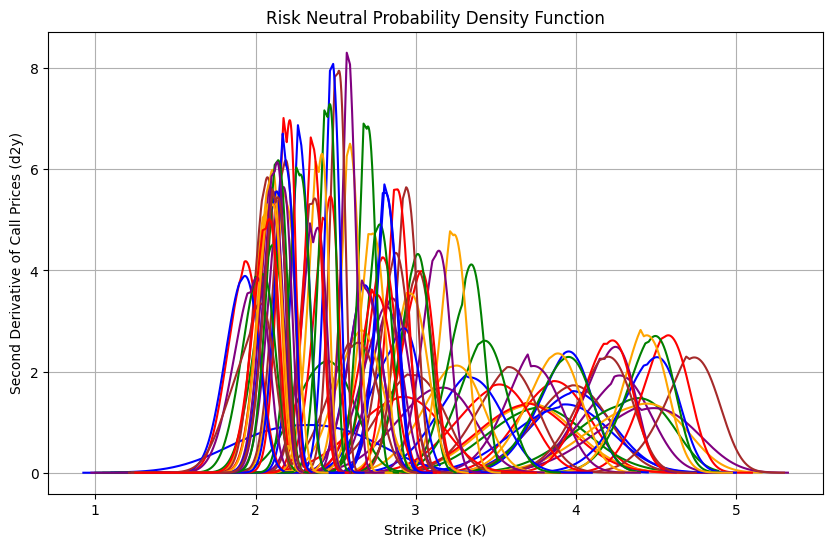

In [10]:
K_ts = []
d2y_ts = []
ST = []

# Iterate through each month
for current_date in unique_exdates:
    all_K = []
    all_d2y = []
    ST.append(data['expiry_price'][(data['exdate'] == current_date)].values[0]/1000)
    
    #data of put
    K = data['strike_price'][(data['exdate'] == current_date) & (data['cp_flag'] == 'P')].values/1000
    T_minus_t = data['duration'][(data['exdate'] == current_date) & (data['cp_flag'] == 'P')].values/360
    St = data['spindx'][(data['exdate'] == current_date) & (data['cp_flag'] == 'P')].values/1000 # 假設當前標的價格相同
    r = data['ret'][(data['exdate'] == current_date) & (data['cp_flag'] == 'P')].values
    P = data['option_price'][(data['exdate'] == current_date) & (data['cp_flag'] == 'P')].values/1000
    IV = data['impl_volatility'][(data['exdate'] == current_date) & (data['cp_flag'] == 'P')].values
    check = pd.to_datetime("2016-01-15", format= "%Y-%m-%d")
    deltas = data['delta'][(data['exdate'] == current_date) & (data['cp_flag'] == 'P')].values
    vegas = data['vega'][(data['exdate'] == current_date) & (data['cp_flag'] == 'P')].values/1000

    # check  validity and clean data
    valid_data = ~np.isnan(IV)
    St = St[valid_data]
    IV = IV[valid_data]
    K = K[valid_data]
    T_minus_t = T_minus_t[valid_data]
    r = r[valid_data]
    deltas = deltas[valid_data]
    vegas = vegas[valid_data]

    sorted_indices = np.argsort(K)
    K = K[sorted_indices]
    deltas = deltas[sorted_indices]
    IV = IV[sorted_indices]
    vegas = vegas[sorted_indices]
    P = P[sorted_indices]
    
    valid_indices = ~np.isnan(deltas)
    deltas_clean = deltas[valid_indices]
    IV_clean = IV[valid_indices]
    vegas_clean = vegas[valid_indices]
    K_clean = K[valid_indices]
    
    sorted_indices = np.argsort(deltas_clean)
    deltas_sorted = deltas_clean[sorted_indices]
    IV_sorted = IV_clean[sorted_indices]
    vegas_sorted = vegas_clean[sorted_indices]
    
    # Fit the spline with sorted and cleaned data
    spline = UnivariateSpline(deltas_sorted, IV_sorted, w=vegas_sorted, s=0.9999)
    knots = 5000
    delta_range = np.linspace(min(deltas), max(deltas), knots)
    smoothed_IV = spline(delta_range)
    
    # Expand St to have 5000 values (same size as smoothed_IV)
    St = np.full(knots, St[0])
    T_minus_t = np.full(knots, T_minus_t[0])
    r = np.full(knots, r[0])
    K_smooth = np.linspace(max(K_clean), min(K_clean), knots)
    put_prices_smooth = black_scholes_price(St, K_smooth, T_minus_t, r, smoothed_IV,type = 'p')
    
    # put price with second derivation
    dy = np.gradient(put_prices_smooth, K_smooth)
    d2y = np.gradient(dy, K_smooth)*np.exp(r * T_minus_t)
    
    # Apply the condition to avoid extreme values
    lower_bound = K[5]
    upper_bound = K[-2]
    condition = (K_smooth >= lower_bound) & (K_smooth <= upper_bound)
    K_smooth = K_smooth[condition]
    d2y = d2y[condition]
    sorted_indices = np.argsort(K_smooth)
    K_smooth = K_smooth[sorted_indices]
    d2y = d2y[sorted_indices]
    
    all_K.append(K_smooth)
    all_d2y.append(d2y)
    
    #call
    K = data['strike_price'][(data['exdate'] == current_date) & (data['cp_flag'] == 'C')].values/1000
    T_minus_t = data['duration'][(data['exdate'] == current_date) & (data['cp_flag'] == 'C')].values/360
    St = data['spindx'][(data['exdate'] == current_date) & (data['cp_flag'] == 'C')].values /1000# 假設當前標的價格相同
    r = data['ret'][(data['exdate'] == current_date) & (data['cp_flag'] == 'C')].values
    P = data['option_price'][(data['exdate'] == current_date) & (data['cp_flag'] == 'C')].values/1000
    IV = data['impl_volatility'][(data['exdate'] == current_date) & (data['cp_flag'] == 'C')].values
    deltas = data['delta'][(data['exdate'] == current_date) & (data['cp_flag'] == 'C')].values
    vegas = data['vega'][(data['exdate'] == current_date) & (data['cp_flag'] == 'C')].values/1000

    # check  validity
    valid_data = ~np.isnan(IV)
    St = St[valid_data]
    IV = IV[valid_data]
    K = K[valid_data]
    T_minus_t = T_minus_t[valid_data]
    r = r[valid_data]
    deltas = deltas[valid_data]
    vegas = vegas[valid_data]

    sorted_indices = np.argsort(K)
    K = K[sorted_indices]
    deltas = deltas[sorted_indices]
    IV = IV[sorted_indices]
    vegas = vegas[sorted_indices]
    P = P[sorted_indices]

    valid_indices = ~np.isnan(deltas)
    deltas_clean = deltas[valid_indices]
    IV_clean = IV[valid_indices]
    vegas_clean = vegas[valid_indices]
    K_clean = K[valid_indices]

    sorted_indices = np.argsort(deltas_clean)
    deltas_sorted = deltas_clean[sorted_indices]
    IV_sorted = IV_clean[sorted_indices]
    vegas_sorted = vegas_clean[sorted_indices]
    

    # Fit the spline with sorted and cleaned data
    spline = UnivariateSpline(deltas_sorted, IV_sorted, w=vegas_sorted, s=0.9999)

    # generate 5000 points in delta space an tranform into delta
    knots = 5000
    delta_range = np.linspace(min(deltas), max(deltas), knots)
    smoothed_IV = spline(delta_range)

    # Expand St to have 5000 values (same size as smoothed_IV)
    St = np.full(knots, St[0])
    T_minus_t = np.full(knots, T_minus_t[0])
    r = np.full(knots, r[0])

    K_smooth = np.linspace(max(K_clean), min(K_clean), knots)
    call_prices_smooth = black_scholes_price(St, K_smooth, T_minus_t, r, smoothed_IV, type = 'c')

    # second differentiation
    dy = np.gradient(call_prices_smooth, K_smooth)
    d2y = np.gradient(dy, K_smooth)*np.exp(r * T_minus_t)

    # Apply the condition to avoid extreme values
    lower_bound = K[2]
    upper_bound = K[-2]
    condition = (K_smooth >= lower_bound) & (K_smooth <= upper_bound)
    K_smooth = K_smooth[condition]
    d2y = d2y[condition]
    
    # Sorting them based on x-values to ensure proper connection of lines
    sorted_indices = np.argsort(K_smooth)
    K_smooth = K_smooth[sorted_indices]
    d2y = d2y[sorted_indices]
    
    # append call part
    all_K.append(K_smooth)
    all_d2y.append(d2y)
    
    # Concatenating x-values (all_K) and y-values (all_d2y)
    combined_K = np.concatenate([all_K[0], all_K[1]])
    combined_d2y = np.concatenate([all_d2y[0], all_d2y[1]])
    
    # Sorting them based on x-values to ensure proper connection of lines
    sorted_indices = np.argsort(combined_K)
    combined_K_sorted = combined_K[sorted_indices]
    combined_d2y_sorted = combined_d2y[sorted_indices]
    combined_d2y_sorted[combined_d2y_sorted < 0] = 0
    
    # record combination of Rpdf
    K_ts.append(combined_K_sorted)
    d2y_ts.append(combined_d2y_sorted)

    
    


# Plotting all d2y vs. K_smooth
plt.figure(figsize=(10, 6))
for i in range(len(d2y_ts)):
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    plt.plot(K_ts[i], d2y_ts[i], color=colors[i % len(colors)])
    
    # Find the maximum point for the current week
    max_index = np.argmax(d2y_ts[i])  # Index of the max value
    max_d2y = d2y_ts[i][max_index]    # Max d2y value
    max_K = K_ts[i][max_index]        # Corresponding K value


plt.xlabel('Strike Price (K)')
plt.ylabel('Second Derivative of Call Prices (d2y)')
plt.title('Risk Neutral Probability Density Function')
plt.grid()
plt.show()


### Berkowitz Test of the risk-neutral probability (Risk-neutral probability is not appropriate)

In [15]:
def inverse_probability_transform(realizations, K_ts, d2y_ts):
    transformed_data = []
    for i in range(len(K_ts)):
        d2y_ts[i] = d2y_ts[i]/np.sum(d2y_ts[i])
        Xi = realizations[i]
        sum_of_pdf = 0
        for j in range(len(K_ts[i])):
            if(Xi >= K_ts[i][j]):
                sum_of_pdf += d2y_ts[i][j]
            else:
                break
        transformed_data.append(sum_of_pdf)
    return np.array(transformed_data)
def normal_transform(y_values):
    z_values = stats.norm.ppf(y_values)
    return z_values
def log_likelihood(y, phi, mean, sigma2):
    T = len(y)
    y = y - mean
    term1 = -0.5 * np.log(2 * np.pi)
    term2 = -0.5 * np.log(sigma2 / (1 - phi**2))
    term3 = -(y[0]**2) / (2 * sigma2 / (1 - phi**2))
    term4 = -((T - 1) / 2) * np.log(2 * np.pi)
    term5 = -((T - 1) / 2) * np.log(sigma2)
    term6 = 0
    for t in range(1, T):
        term6 -= ((y[t] -  phi * y[t - 1])**2) / (2 * sigma2)
    
    log_likelihood_value = term1 + term2 + term3 + term4 + term5 + term6
    return log_likelihood_value
def berkowitz_test(z_values):
    # Estimate AR(1) on transformed data
    z_series = np.array(z_values)
    model = AutoReg(z_series, lags=1)
    fit = model.fit()
    rho = fit.params[1]  # Autoregressive term
    residuals = fit.resid
    var = np.var(residuals)
    mean = np.mean(z_values)
    
    # Compute LR1 test statistic
    log_likelihood_null = log_likelihood(z_values, 0, mean, var)
    log_likelihood_alternative = log_likelihood(z_values, rho, mean, var)
    LR1_statistic = -2 * (log_likelihood_null - log_likelihood_alternative)
    
    df = 1
    # Calculate the p-value using the survival function (1 - CDF)
    p_value = stats.chi2.sf(LR1_statistic, df)
    print({"LR1_statistic": LR1_statistic, "rho": rho, "mean": mean, "variance": var, "p_value": p_value})


    # Compute LR3 test statistic
    log_likelihood_null = log_likelihood(z_values, 0, 0, 1)
    log_likelihood_alternative = log_likelihood(z_values, rho, mean, var)
    LR3_statistic = -2 * (log_likelihood_null - log_likelihood_alternative)

    df = 3
    # Calculate the p-value using the survival function (1 - CDF)
    p_value = stats.chi2.sf(LR3_statistic, df)

    print( {"LR3_statistic": LR3_statistic, "rho": rho, "mean": mean, "variance": var, "p_value": p_value})


In [16]:
uniform_val = inverse_probability_transform(ST, K_ts, d2y_ts)
std_val = normal_transform(uniform_val)
berkowitz_results = berkowitz_test(std_val)

{'LR1_statistic': np.float64(0.06469537099548006), 'rho': np.float64(-0.026931170382587286), 'mean': np.float64(-0.24746738482099098), 'variance': np.float64(0.859877194854785), 'p_value': np.float64(0.799222975532125)}
{'LR3_statistic': np.float64(6.715446959002122), 'rho': np.float64(-0.026931170382587286), 'mean': np.float64(-0.24746738482099098), 'variance': np.float64(0.859877194854785), 'p_value': np.float64(0.08154226062567656)}


### Monte Carlo and Bootstrap Test to find the optimal risk parameter from adjusted pdf

In [20]:
#changing q-measure to p-measure
def adjusted_pdf(K_ts, d2y_ts, gamma):
    p_ST = []
    for i in range(len(d2y_ts)):
        max_val = np.max(-gamma * K_ts[i])
        p_ST_temp = d2y_ts[i] * np.exp(-gamma * K_ts[i])
        prob = p_ST_temp / np.sum(p_ST_temp) # Normalize so it integrates to 1
        p_ST.append(prob)
    return p_ST
    

# Compute the Berkowitz test p-value for a given gamma
def berkowitz_test(gamma, pseudo_outcome, K_ts, d2y_ts):
    # Get adjusted PDF values for the candidate gamma
    p_ST = adjusted_pdf(K_ts, d2y_ts, gamma)
    y_values = inverse_probability_transform(pseudo_outcome, K_ts, p_ST)  
    z_values = normal_transform(y_values)  

    # Estimate AR(1) on transformed data
    z_series = np.array(z_values)
    z_series = z_series[np.isfinite(z_series)]
    model = AutoReg(z_series, lags=1)
    fit = model.fit()
    rho = fit.params[1]  # Autoregressive term
    residuals = fit.resid
    var = np.var(residuals)
    mean = np.mean(z_values)

   
    # Compute LR3 test statistic
    log_likelihood_null = log_likelihood(z_values, 0, 0, 1)
    log_likelihood_alternative = log_likelihood(z_values, rho, mean, var)
    LR3_statistic = -2 * (log_likelihood_null - log_likelihood_alternative)
    p_value = stats.chi2.sf(LR3_statistic, 3)

    return -p_value  # Return negative p-value to maximize it

In [22]:
n_sim = 100
mon_gamma = []
mon_p_val = []
for i in range(n_sim):
    pseudo_outcome = []
    pseudo_prob = []
    
    for j in range(len(K_ts)):
        Xi = np.random.choice(K_ts[j], size=1, replace=True, p=d2y_ts[j])[0]
        p = d2y_ts[j][K_ts[j].tolist().index(Xi)]
        pseudo_outcome.append(Xi)
        pseudo_prob.append(p)

    try:
        initial_guess = 0
        bounds = [(-10, 10)]
        # result = differential_evolution(berkowitz_test, bounds, args=(pseudo_outcome, K_ts, d2y_ts),maxiter = 20,tol=1e-16)
        result = minimize(berkowitz_test, initial_guess, args=(pseudo_outcome, K_ts, d2y_ts), bounds=[(-10, 10)], tol=1e-25)
        optimal_gamma = result.x[0]
        p_value = -berkowitz_test(optimal_gamma, pseudo_outcome, K_ts, d2y_ts)  # Get p-value for optimal gamma
        print("index: ",i)
        print("inital guess: ", initial_guess)
        print("optimal gamma: ",optimal_gamma)
        print("p value: ",p_value)
        mon_gamma.append(optimal_gamma)
        mon_p_val.append(p_value)
    except ValueError as e:
        print(f"Iteration {i} skipped due to error: {e}")
        continue

index:  0
inital guess:  0
optimal gamma:  -0.43047020623069837
p value:  0.9294115633238234
index:  1
inital guess:  0
optimal gamma:  -0.3839710171235759
p value:  0.1557478362521578
index:  2
inital guess:  0
optimal gamma:  1.144654399599498
p value:  0.9890620160331154
index:  3
inital guess:  0
optimal gamma:  -0.006568422661165346
p value:  0.9811524843217035
index:  4
inital guess:  0
optimal gamma:  0.9416404958180589
p value:  0.9392836113104824
index:  5
inital guess:  0
optimal gamma:  0.28594779129739295
p value:  0.5759303862659508
index:  6
inital guess:  0
optimal gamma:  -0.021025404362405804
p value:  0.5584920127727884
index:  7
inital guess:  0
optimal gamma:  0.12200032067844531
p value:  0.20517816031018057
index:  8
inital guess:  0
optimal gamma:  0.8253490134039333
p value:  0.8526011694729645
index:  9
inital guess:  0
optimal gamma:  -1.1390075760683431
p value:  0.9422645967244743
index:  10
inital guess:  0
optimal gamma:  0.27835677013740057
p value:  0.47

Monte Carlo Method Standard Deviation:  0.8379878430479598


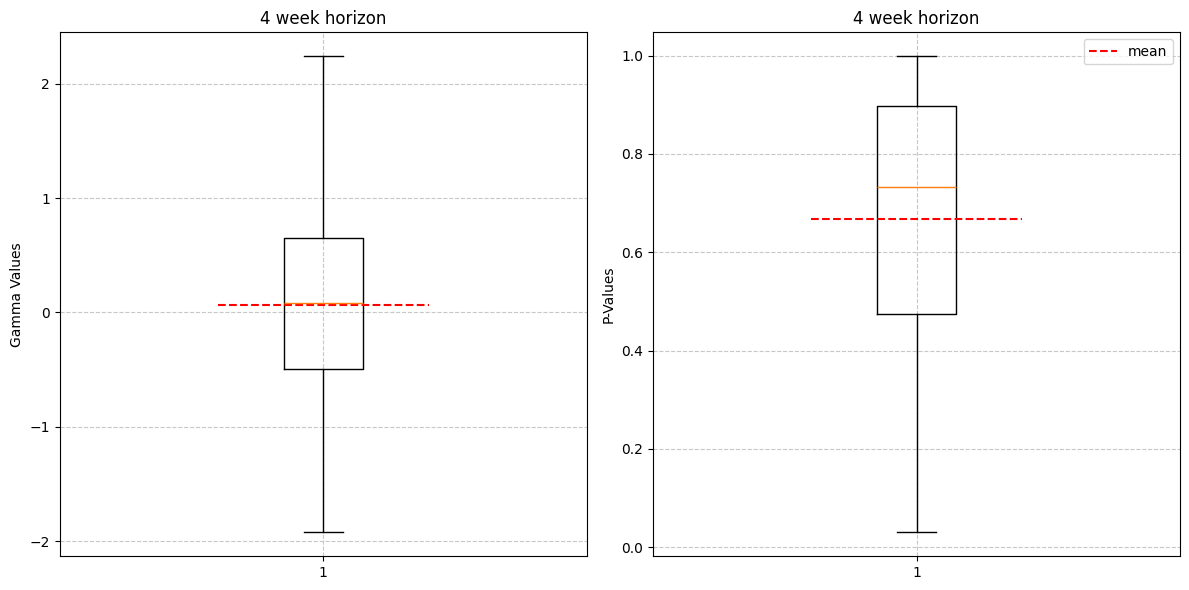

In [23]:
mean_gamma = np.mean(mon_gamma)
mean_p_val = np.mean(mon_p_val)
stdev = np.std(mon_gamma)
print("Monte Carlo Method Standard Deviation: ", stdev)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot mon_gamma on the left
axs[0].boxplot(mon_gamma, showfliers=True)
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].set_title('4 week horizon')
axs[0].set_ylabel('Gamma Values')
axs[0].hlines(mean_gamma, xmin=0.8, xmax=1.2, colors='red', linestyles='--', label='mean')

# Plot p_val on the right
axs[1].boxplot(mon_p_val, showfliers=True)
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].set_title('4 week horizon')
axs[1].set_ylabel('P-Values')
axs[1].hlines(mean_p_val, xmin=0.8, xmax=1.2, colors='red', linestyles='--', label='mean')
axs[1].legend(loc='upper right')  

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [24]:
# Bootstrap Testing
n_sim = 100
boot_gamma = []
boot_p_val = []
boot_RRA = []

boot_outcome = []
boot_K = []
boot_d2y = []

for i in range(n_sim):
    # Sample indices based on ST array
    boot_outcome = []
    boot_K = []
    boot_d2y = []
    indices = np.random.choice(len(ST), size=len(ST), replace=True)
    for val in indices:
        boot_outcome.append(ST[val])
        boot_K.append(K_ts[val])
        boot_d2y.append(d2y_ts[val])
    
    try:
        bounds = [(-10, 10)]  
        initial_guess = 0
        
        # Run differential evolution
        # result = differential_evolution(berkowitz_test, bounds, args=(boot_outcome, boot_K, boot_d2y),tol=1e-16)
        result = minimize(berkowitz_test, initial_guess, args=(boot_outcome, boot_K, boot_d2y), bounds=[(-10, 10)], tol = 1e-25)
        optimal_gamma = result.x[0]
        p_value = -berkowitz_test(optimal_gamma, boot_outcome, boot_K, boot_d2y)  # Get p-value for optimal gamma
        RRA = optimal_gamma*np.mean(boot_outcome)
        print("index: ",i)
        print("inital guess: ", initial_guess)
        print("optimal gamma: ",optimal_gamma)
        print("RRA: ",RRA)
        print("p value: ",p_value)
        boot_gamma.append(optimal_gamma)
        boot_p_val.append(p_value)
        boot_RRA.append(RRA)
    except ValueError as e:
        print(f"Iteration {i} skipped due to error: {e}")
        continue

index:  0
inital guess:  0
optimal gamma:  0.9183827424263905
RRA:  2.8620036740993706
p value:  0.24255728577178212
index:  1
inital guess:  0
optimal gamma:  2.544702304869383
RRA:  7.899030558453398
p value:  0.8207329642253565
index:  2
inital guess:  0
optimal gamma:  2.8938655892294687
RRA:  8.85449156233494
p value:  0.18197782185505976
index:  3
inital guess:  0
optimal gamma:  3.394281461993338
RRA:  9.825342250492513
p value:  0.185693257430105
index:  4
inital guess:  0
optimal gamma:  1.7939876785674687
RRA:  5.409134654797086
p value:  0.7927620198429406
index:  5
inital guess:  0
optimal gamma:  3.3747176837794948
RRA:  10.335411490887372
p value:  0.3078911613268636
index:  6
inital guess:  0
optimal gamma:  2.7946504640668515
RRA:  8.301495690914933
p value:  0.6284390562760171
index:  7
inital guess:  0
optimal gamma:  1.8868219464078093
RRA:  5.975232318644522
p value:  0.9065258410917604
index:  8
inital guess:  0
optimal gamma:  1.355544060304154
RRA:  4.13874429466

In [25]:
minimum = np.min(boot_RRA)

# Mean
mean = np.mean(boot_RRA)

# Median
median = np.median(boot_RRA)

# Probability of values < 0
prob_less_than_zero = np.mean(np.array(boot_RRA) < 0)

# Standard deviation
std_dev = np.std(boot_RRA)

# Print the results
print(f"Minimum: {minimum}")
print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Probability of < 0: {prob_less_than_zero}")
print(f"Standard deviation: {std_dev}")

Minimum: -0.9355892345228372
Mean: 5.9428394256238555
Median: 6.051707705351488
Probability of < 0: 0.01
Standard deviation: 2.399497950229874


Optimal Relative Risk Aversion for real outcome:  6.28708541108747


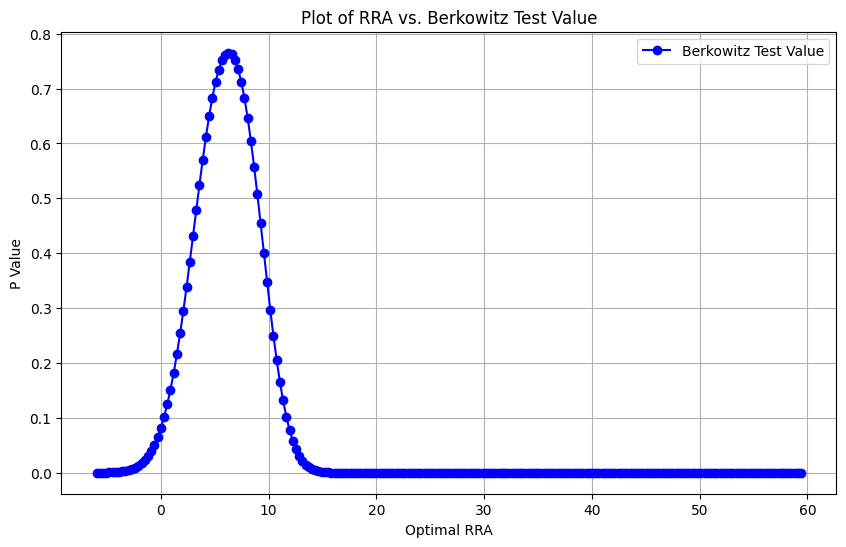

In [26]:
import matplotlib.pyplot as plt

# Initialize lists
re = []
optimal_gamma_values = np.arange(-2, 20, 0.1)

# Compute Berkowitz test values for each optimal_gamma
for i in optimal_gamma_values:
    # Assuming real_outcome, K_ts, d2y_ts are defined elsewhere
    berkowitz_value = -berkowitz_test(i, ST, K_ts, d2y_ts)
    re.append(berkowitz_value)

result = minimize(berkowitz_test, initial_guess, args=(ST, K_ts, d2y_ts), bounds=[(-10, 10)], tol = 1e-25)
optimal_gamma = result.x[0]
p_value = -berkowitz_test(optimal_gamma, ST, K_ts, d2y_ts)
print("Optimal Relative Risk Aversion for real outcome: ", optimal_gamma*np.mean(ST))


# Plot optimal_gamma vs. Berkowitz test values
plt.figure(figsize=(10, 6))
plt.plot(optimal_gamma_values*np.mean(ST), re, marker='o', color='b', label='Berkowitz Test Value')
plt.xlabel('Optimal RRA')
plt.ylabel('P Value')
plt.title('Plot of RRA vs. Berkowitz Test Value')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# Compute the Berkowitz test p-value for a given gamma
def berkowitz_test_3(gamma, pseudo_outcome, K_ts, d2y_ts):
    # Get adjusted PDF values for the candidate gamma
    p_ST = adjusted_pdf(K_ts, d2y_ts, gamma)
    y_values = inverse_probability_transform(pseudo_outcome, K_ts, p_ST)  
    z_values = normal_transform(y_values)  

    # Estimate AR(1) on transformed data
    z_series = np.array(z_values)
    z_series = z_series[np.isfinite(z_series)]
    model = AutoReg(z_series, lags=1)
    fit = model.fit()
    rho = fit.params[1]  # Autoregressive term
    residuals = fit.resid
    var = np.var(residuals)
    mean = np.mean(z_values)

   
    # Compute LR3 test statistic
    log_likelihood_null = log_likelihood(z_values, 0, 0, 1)
    log_likelihood_alternative = log_likelihood(z_values, rho, mean, var)
    LR3_statistic = -2 * (log_likelihood_null - log_likelihood_alternative)
    p_value = stats.chi2.sf(LR3_statistic, 3)

    return -p_value  # Return negative p-value to maximize it

# Compute the Berkowitz test p-value for a given gamma
def berkowitz_test_1(gamma, pseudo_outcome, K_ts, d2y_ts):
    # Get adjusted PDF values for the candidate gamma
    p_ST = adjusted_pdf(K_ts, d2y_ts, gamma)
    y_values = inverse_probability_transform(pseudo_outcome, K_ts, p_ST)  
    z_values = normal_transform(y_values)  

    # Estimate AR(1) on transformed data
    z_series = np.array(z_values)
    z_series = z_series[np.isfinite(z_series)]
    model = AutoReg(z_series, lags=1)
    fit = model.fit()
    rho = fit.params[1]  # Autoregressive term
    residuals = fit.resid
    var = np.var(residuals)
    mean = np.mean(z_values)

   
    # Compute LR3 test statistic
    log_likelihood_null = log_likelihood(z_values, 0, mean, var)
    log_likelihood_alternative = log_likelihood(z_values, rho, mean, var)
    LR3_statistic = -2 * (log_likelihood_null - log_likelihood_alternative)
    p_value = stats.chi2.sf(LR3_statistic, 1)

    return -p_value  # Return negative p-value to maximize it

result = minimize(berkowitz_test_3, initial_guess, args=(ST, K_ts, d2y_ts), bounds=[(-10, 10)], tol = 1e-25)
optimal_gamma = result.x[0]
LR_3_p_value = -berkowitz_test_3(optimal_gamma, ST, K_ts, d2y_ts)
LR_1_p_value = -berkowitz_test_1(optimal_gamma, ST, K_ts, d2y_ts)
print("Optimal Relative Risk Aversion for real outcome: ", optimal_gamma*np.mean(ST))
print("LR3:", LR_3_p_value)
print("LR1:", LR_1_p_value)

Optimal Relative Risk Aversion for real outcome:  6.28708541108747
LR3: 0.7652147977702741
LR1: 0.8640234469931942
